**CNNs (Convolutional Neural Networks) for MRI**

Basic Steps for building CNN model

1. Import deep learning libraries (in this case I chose Tensorflow and Keras)
2. Process image data (resizing/normalizing/augmenting, and splitting into training and testing sets)
3. Defining model architecture: specify number and size of convolutional and pooling layers, activation functions and number of neurons in fully connected layers. Usually activation functions are ReLU (rectified linear units). We can also use pre-trained models w/ transfer learning and improve accuracy of models (most commonly used algorithms are VGG16 and ResNet50; ImageNet is most commonly used pre-training dataset)
4. Compile the model (specify loss function/optimizer/evaluation metrics used to train and evaluate model)
5. Train model on training data with 'fit' function and evaluate with 'evaluate' function
6. Use trained model to make predictions on testing data with 'predict' function

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from tensorflow.keras.layers import (BatchNormalization, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D)
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
train_data_dir = './train'
test_data_dir = './test'

In [45]:
datagen = ImageDataGenerator(rescale=1./255) #rescales pixel values so all pixel values fall within same range

batch_size = 32 #number of training examples in one forward/backward pass. higher batch size = more memory space needed

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150), #resized to 150px by 150px
        batch_size=batch_size,
        class_mode='categorical') #class_mode = 'categorical' one-hot code

validation_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
print(train_generator.class_indices)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [12]:
model = tf.keras.models.Sequential([ #initiate sequential model object (linear stack of layers)
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)), #adds 2D convolutional layer w/ 16 filters size 3x3. input shape = 150x150 pixels with 3 color channels (RBG)
    tf.keras.layers.MaxPooling2D(2,2), #adds 2D max pooling layer to model, downsampling input by taking max value of 2x2 window in input feature map
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), #flattens input feature map into 1D vector to be passed to fully connected layer
    tf.keras.layers.Dense(512, activation='relu'), #adds fully connected layer w/ 512 unit and ReLU activation
    tf.keras.layers.Dense(4, activation='softmax')  #adds fully connected layer with 4 units (one for each class) and softmax activation
])

#softmax function converts output into probability distribution over 4 classes

#resulted in accuracy of around 74%


In [19]:
#model version 2 based on "Accurate brain tumor detection using deep convolutional neural network"
ini_input = keras.Input(shape=(150, 150, 3), name="image")

x1 = layers.Conv2D(64, (22, 22), strides=2)(ini_input)
x1 = layers.MaxPooling2D((3, 3))(x1)
x1 = layers.BatchNormalization()(x1)

x2 = layers.Conv2D(128, (11, 11), strides=2, padding="same")(x1)
x2 = layers.MaxPooling2D((2, 2))(x2)
x2 = layers.BatchNormalization()(x2)

x3 = layers.Conv2D(256, (7, 7), strides=2, padding="same")(x2)
x3 = layers.MaxPooling2D((2, 2))(x3)
x3 = layers.BatchNormalization()(x3)

x4 = layers.Conv2D(512, (3, 3), strides=2, padding="same")(x3)
x4 = layers.MaxPooling2D((2, 2), padding='same')(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)

x5 = layers.GlobalAveragePooling2D()(x4)
x5 = layers.Dense(1024, activation="relu")(x5)
x5 = layers.BatchNormalization()(x5)

x6 = layers.Dense(512, activation="relu")(x5)
x6 = layers.BatchNormalization()(x6)

x7 = layers.Dense(256, activation="relu")(x6)
x7 = layers.BatchNormalization()(x7)

x8 = layers.Dropout(.2)(x7)
x9 = layers.Dense(4, activation="softmax")(x8)

model_v2 = keras.Model(inputs=ini_input, outputs=x9)


categorical cross-entropy is used for multi-class classification problems
- it measures dissimilarity between predicted probability distribution over all possible classes and true probability distribution. 
- the predicted probability distribution is vector of probabilities,
- each element represents probability of corresponding class
- true probability distribution is also vector with value of 1 for true class and 0 for all other classes.

categorical cross entropy = avg. of cross-entropy loss over all samples in dataset. measures how well predicted probability distribution matches true probability distribution; is used as objective function in training to update model parameter to minimize loss.

categorical cross-entropy loss for single sample is given by:

L = - ∑ y_i * log(p_i)

y_i = true probability distribuiton (one-hot encoded vector)
p_i is predicted probability distribution (softmax output) for i-th class.



In [21]:
#og basic model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=80,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//validation_generator.batch_size)

Epoch 1/80
89/89 [==============================] - 58s 611ms/step - loss: 0.8641 - accuracy: 0.6342 - val_loss: 2.0481 - val_accuracy: 0.4740
Epoch 2/80
89/89 [==============================] - 58s 649ms/step - loss: 0.4232 - accuracy: 0.8372 - val_loss: 2.0829 - val_accuracy: 0.6562
Epoch 3/80
89/89 [==============================] - 54s 610ms/step - loss: 0.2792 - accuracy: 0.8925 - val_loss: 2.5185 - val_accuracy: 0.6432
Epoch 4/80
89/89 [==============================] - 55s 612ms/step - loss: 0.1334 - accuracy: 0.9538 - val_loss: 2.5765 - val_accuracy: 0.6849
Epoch 5/80
89/89 [==============================] - 57s 637ms/step - loss: 0.0694 - accuracy: 0.9767 - val_loss: 3.3323 - val_accuracy: 0.6276
Epoch 6/80
89/89 [==============================] - 64s 707ms/step - loss: 0.0504 - accuracy: 0.9831 - val_loss: 2.8182 - val_accuracy: 0.7500
Epoch 7/80
89/89 [==============================] - 55s 616ms/step - loss: 0.0496 - accuracy: 0.9834 - val_loss: 4.0991 - val_accuracy: 0.7474

Epoch 57/80
89/89 [==============================] - 37s 414ms/step - loss: 3.3986e-06 - accuracy: 1.0000 - val_loss: 8.8481 - val_accuracy: 0.7214
Epoch 58/80
89/89 [==============================] - 42s 469ms/step - loss: 3.2271e-06 - accuracy: 1.0000 - val_loss: 9.1553 - val_accuracy: 0.7161
Epoch 59/80
89/89 [==============================] - 44s 497ms/step - loss: 3.0961e-06 - accuracy: 1.0000 - val_loss: 9.0794 - val_accuracy: 0.7240
Epoch 60/80
89/89 [==============================] - 39s 442ms/step - loss: 2.9253e-06 - accuracy: 1.0000 - val_loss: 9.0379 - val_accuracy: 0.7188
Epoch 61/80
89/89 [==============================] - 42s 469ms/step - loss: 2.7580e-06 - accuracy: 1.0000 - val_loss: 9.1356 - val_accuracy: 0.7188
Epoch 62/80
89/89 [==============================] - 42s 470ms/step - loss: 2.5940e-06 - accuracy: 1.0000 - val_loss: 8.9485 - val_accuracy: 0.7266
Epoch 63/80
89/89 [==============================] - 41s 462ms/step - loss: 2.4835e-06 - accuracy: 1.0000 - val_

In [30]:
test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

model.evaluate(test_generator)


Found 394 images belonging to 4 classes.
13/13 [==============================] - 2s 143ms/step - loss: 9.7082 - accuracy: 0.7234


[9.708248138427734, 0.7233502268791199]

In [46]:
Y_pred = model.predict(test_generator)
testy = test_generator.classes

# Convert predictions from one-hot encoding to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Generate the classification report
print('Classification Report')
target_names = ['Glioma','Meningioma', 'No Tumor', 'Pituitary']
print(classification_report(testy, Y_pred_classes, target_names=target_names))

13/13 [==============================] - 2s 173ms/step
Classification Report
              precision    recall  f1-score   support

      Glioma       0.90      0.18      0.30       100
  Meningioma       0.71      0.99      0.83       115
    No Tumor       0.65      1.00      0.79       105
   Pituitary       0.92      0.65      0.76        74

    accuracy                           0.72       394
   macro avg       0.80      0.70      0.67       394
weighted avg       0.78      0.72      0.67       394



The 'basic' model correctly identified % of images in the dataset. The model's loss value on the dataset was 5.72. Loss value is equal to the average difference between predicted output of the model and actual output. 

In [20]:
#pre-made model
model_v2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_v2 = model_v2.fit(train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs=80,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n//validation_generator.batch_size)

Epoch 1/80
89/89 [==============================] - 115s 1s/step - loss: 1.0396 - accuracy: 0.6180 - val_loss: 3.9780 - val_accuracy: 0.2578
Epoch 2/80
89/89 [==============================] - 101s 1s/step - loss: 0.7133 - accuracy: 0.7241 - val_loss: 2.3187 - val_accuracy: 0.4271
Epoch 3/80
89/89 [==============================] - 121s 1s/step - loss: 0.5490 - accuracy: 0.7875 - val_loss: 2.6314 - val_accuracy: 0.3516
Epoch 4/80
89/89 [==============================] - 153s 2s/step - loss: 0.4295 - accuracy: 0.8460 - val_loss: 2.6268 - val_accuracy: 0.5651
Epoch 5/80
89/89 [==============================] - 149s 2s/step - loss: 0.3936 - accuracy: 0.8499 - val_loss: 2.9447 - val_accuracy: 0.4323
Epoch 6/80
89/89 [==============================] - 146s 2s/step - loss: 0.3159 - accuracy: 0.8876 - val_loss: 6.0786 - val_accuracy: 0.3307
Epoch 7/80
89/89 [==============================] - 148s 2s/step - loss: 0.2159 - accuracy: 0.9211 - val_loss: 3.9104 - val_accuracy: 0.3776
Epoch 8/80
89

89/89 [==============================] - 99s 1s/step - loss: 0.0094 - accuracy: 0.9982 - val_loss: 2.8052 - val_accuracy: 0.7370
Epoch 59/80
89/89 [==============================] - 95s 1s/step - loss: 0.0087 - accuracy: 0.9979 - val_loss: 2.2215 - val_accuracy: 0.7318
Epoch 60/80
89/89 [==============================] - 99s 1s/step - loss: 0.0382 - accuracy: 0.9884 - val_loss: 2.5784 - val_accuracy: 0.7422
Epoch 61/80
89/89 [==============================] - 86s 957ms/step - loss: 0.0403 - accuracy: 0.9887 - val_loss: 5.1334 - val_accuracy: 0.6380
Epoch 62/80
89/89 [==============================] - 97s 1s/step - loss: 0.0321 - accuracy: 0.9905 - val_loss: 2.5592 - val_accuracy: 0.7422
Epoch 63/80
89/89 [==============================] - 86s 965ms/step - loss: 0.0133 - accuracy: 0.9961 - val_loss: 2.6359 - val_accuracy: 0.7526
Epoch 64/80
89/89 [==============================] - 103s 1s/step - loss: 0.0188 - accuracy: 0.9933 - val_loss: 2.1669 - val_accuracy: 0.7448
Epoch 65/80
89/89 

In [24]:
#premade model
test_generator_v2 = datagen.flow_from_directory(
        test_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

model_v2.evaluate(test_generator_v2)


Found 394 images belonging to 4 classes.
13/13 [==============================] - 8s 633ms/step - loss: 2.4117 - accuracy: 0.7716


[2.4117071628570557, 0.7715736031532288]

In [47]:
#premade model
Y_pred_2 = model_v2.predict(test_generator_v2)
testy_2 = test_generator_v2.classes

# Convert predictions from one-hot encoding to class labels
Y_pred_classes_2 = np.argmax(Y_pred_2, axis=1)

# Generate the classification report
print('Classification Report')
target_names = ['Glioma','Meningioma', 'No Tumor', 'Pituitary']
print(classification_report(testy_2, Y_pred_classes_2, target_names=target_names))

13/13 [==============================] - 4s 317ms/step
Classification Report
              precision    recall  f1-score   support

      Glioma       1.00      0.18      0.31       100
  Meningioma       0.75      0.99      0.85       115
    No Tumor       0.70      1.00      0.83       105
   Pituitary       0.89      0.91      0.90        74

    accuracy                           0.77       394
   macro avg       0.84      0.77      0.72       394
weighted avg       0.83      0.77      0.72       394



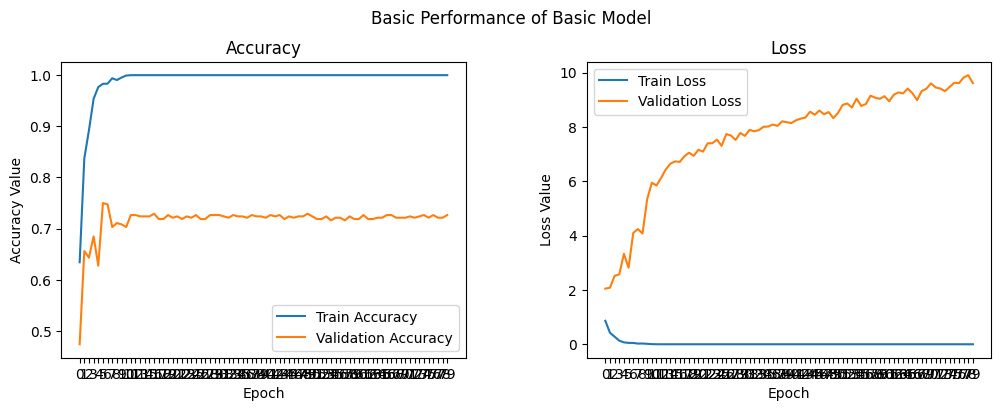

In [43]:
#og model
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic Performance of Basic Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,80))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 80, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 80, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

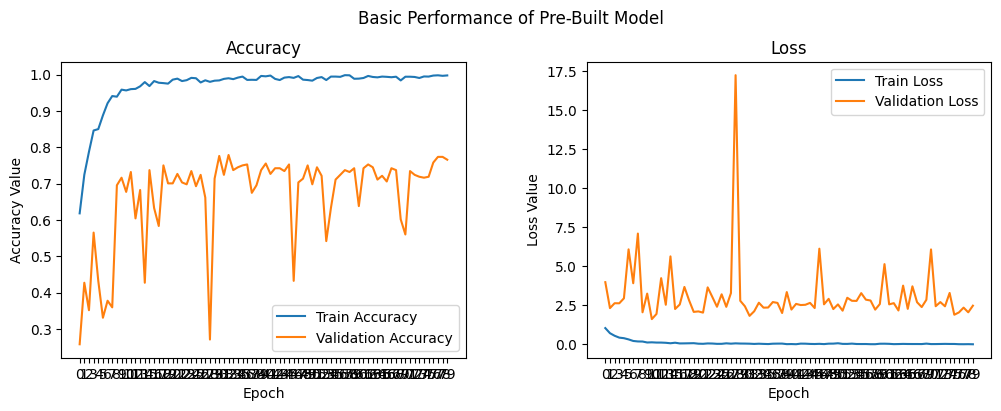

In [42]:
#pre-built model
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic Performance of Pre-Built Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,80))
ax1.plot(epoch_list, history_v2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history_v2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 80, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_v2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history_v2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 80, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [36]:
conv = VGG16(input_shape= (150, 150, 3),weights='imagenet',include_top=False)
conv.output
for layer in conv.layers:
    layer.trainable = False

In [37]:
x = conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
x=  Dropout(.2)(x)
pred = Dense(4,activation='softmax')(x)
vgg_model = Model(inputs = conv.input,outputs=pred)

In [38]:
datagen_vgg = ImageDataGenerator(rescale=1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    validation_split=0.2) #rescales pixel values so all pixel values fall within same range

batch_size = 32 #number of training examples in one forward/backward pass. higher batch size = more memory space needed

train_gen = datagen_vgg.flow_from_directory(
        train_data_dir,
        target_size=(150, 150), #resized to 150px by 150px
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False) #class_mode = 'categorical' one-hot code

validation_gen = datagen_vgg.flow_from_directory(
        test_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False)

vgg_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [39]:
step_size_train=train_gen.n//train_gen.batch_size
vgg_history = vgg_model.fit(train_gen, steps_per_epoch=step_size_train, epochs=40,  verbose=1, validation_data=validation_gen)

Epoch 1/40
89/89 [==============================] - 386s 4s/step - loss: 1.5213 - accuracy: 0.2340 - val_loss: 1.4234 - val_accuracy: 0.2183
Epoch 2/40
89/89 [==============================] - 362s 4s/step - loss: 1.3504 - accuracy: 0.3957 - val_loss: 1.8918 - val_accuracy: 0.2741
Epoch 3/40
89/89 [==============================] - 354s 4s/step - loss: 1.3288 - accuracy: 0.3834 - val_loss: 1.3917 - val_accuracy: 0.2919
Epoch 4/40
89/89 [==============================] - 355s 4s/step - loss: 1.1670 - accuracy: 0.4852 - val_loss: 1.8818 - val_accuracy: 0.3553
Epoch 5/40
89/89 [==============================] - 353s 4s/step - loss: 1.1933 - accuracy: 0.4193 - val_loss: 1.4241 - val_accuracy: 0.2716
Epoch 6/40
89/89 [==============================] - 356s 4s/step - loss: 1.0215 - accuracy: 0.5215 - val_loss: 1.4339 - val_accuracy: 0.3909
Epoch 7/40
89/89 [==============================] - 355s 4s/step - loss: 0.9543 - accuracy: 0.5592 - val_loss: 1.6360 - val_accuracy: 0.3401
Epoch 8/40
89

In [40]:
test_gen = datagen_vgg.flow_from_directory(
        test_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

vgg_model.evaluate(test_gen)

Found 394 images belonging to 4 classes.
13/13 [==============================] - 42s 3s/step - loss: 1.7625 - accuracy: 0.5152


[1.762536883354187, 0.5152284502983093]

In [41]:
#pretrained model
Y_pred_gen = model_v2.predict(test_gen)
testy_gen = test_gen.classes

# Convert predictions from one-hot encoding to class labels
Y_pred_classes_gen = np.argmax(Y_pred_gen, axis=1)

# Generate the classification report
print('Classification Report')
target_names = ['Glioma','Meningioma', 'No Tumor', 'Pituitary']
print(classification_report(testy_gen, Y_pred_classes_gen, target_names=target_names))

13/13 [==============================] - 6s 484ms/step
Classification Report
              precision    recall  f1-score   support

      Glioma       0.50      0.12      0.19       100
  Meningioma       0.41      0.60      0.48       115
    No Tumor       0.46      0.70      0.56       105
   Pituitary       0.43      0.24      0.31        74

    accuracy                           0.44       394
   macro avg       0.45      0.41      0.39       394
weighted avg       0.45      0.44      0.40       394



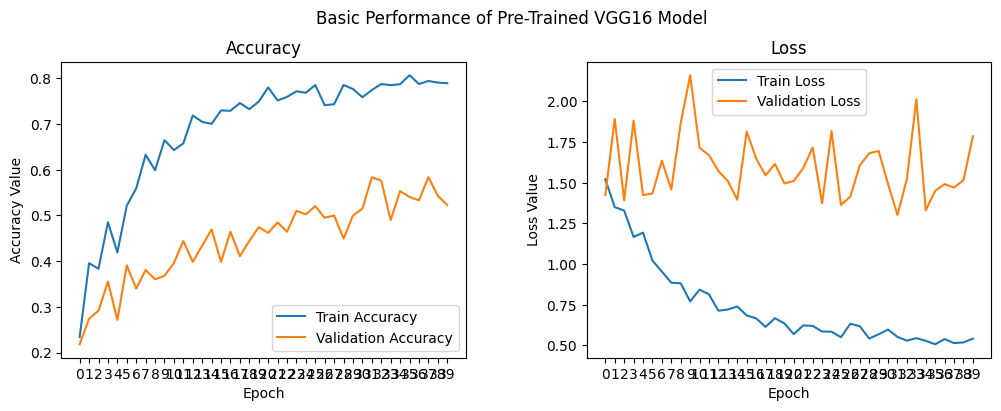

In [49]:

#pre-trained VGG16 model
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic Performance of Pre-Trained VGG16 Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,40))
ax1.plot(epoch_list, vgg_history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, vgg_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 40, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, vgg_history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, vgg_history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 40, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")